In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
import os

# set gpu devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# difine datasets
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.folder_names = os.listdir(root_dir)[0:100]
        self.class_to_idx = {folder_name: idx for idx, folder_name in enumerate(self.folder_names)}
        self.images = self.make_dataset()

    def make_dataset(self):
        images = []
        for folder_name in self.folder_names:
            folder_path = os.path.join(self.root_dir, folder_name)
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        image_path = os.path.join(folder_path, filename)
                        item = (image_path, self.class_to_idx[folder_name])
                        images.append(item)
        return images

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

# data preprocessing
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),         
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# training parameters
batch_size = 128
num_epochs = 50
learning_rate = 0.001
lambda_reg= 0

# create a dataset
dataset = CustomDataset("add_mask_face_dataset", transform=data_transform)

# train/val split
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# dataloader
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# load pretrained model
model = models.resnet18(pretrained=True)

# substitute the classifcation head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.class_to_idx))
model=nn.DataParallel(model)

# move the model to GPU
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# empty list to store losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# training
for epoch in range(num_epochs):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    model.train() 
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # add regularization
        regularization_loss = 0.0
        for param in model.parameters():
            regularization_loss += torch.norm(param, p=2)

        total_loss = loss + lambda_reg * regularization_loss

        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

       
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_data_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # evaluate on validation
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    model.eval()  
    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_data_loader)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    torch.save(model.state_dict(),"resnet.ckpt")
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch [1/50], Train Loss: 3.3653, Train Accuracy: 17.80%, Val Loss: 3.0435, Val Accuracy: 24.06%
Epoch [2/50], Train Loss: 2.2463, Train Accuracy: 40.25%, Val Loss: 2.5855, Val Accuracy: 31.33%
Epoch [3/50], Train Loss: 1.6022, Train Accuracy: 55.78%, Val Loss: 2.2581, Val Accuracy: 41.52%
Epoch [4/50], Train Loss: 1.1208, Train Accuracy: 68.87%, Val Loss: 1.9461, Val Accuracy: 50.13%
Epoch [5/50], Train Loss: 0.6966, Train Accuracy: 80.76%, Val Loss: 1.7915, Val Accuracy: 55.54%
Epoch [6/50], Train Loss: 0.4053, Train Accuracy: 89.10%, Val Loss: 1.7952, Val Accuracy: 56.95%
Epoch [7/50], Train Loss: 0.1955, Train Accuracy: 95.26%, Val Loss: 1.6177, Val Accuracy: 61.67%
Epoch [8/50], Train Loss: 0.0863, Train Accuracy: 98.04%, Val Loss: 1.5997, Val Accuracy: 62.77%
Epoch [9/50], Train Loss: 0.0584, Train Accuracy: 98.86%, Val Loss: 1.7115, Val Accuracy: 61.77%
Epoch [10/50], Train Loss: 0.0544, Train Accuracy: 98.81%, Val Loss: 1.7924, Val Accuracy: 60.79%
Epoch [11/50], Train Loss: 0.

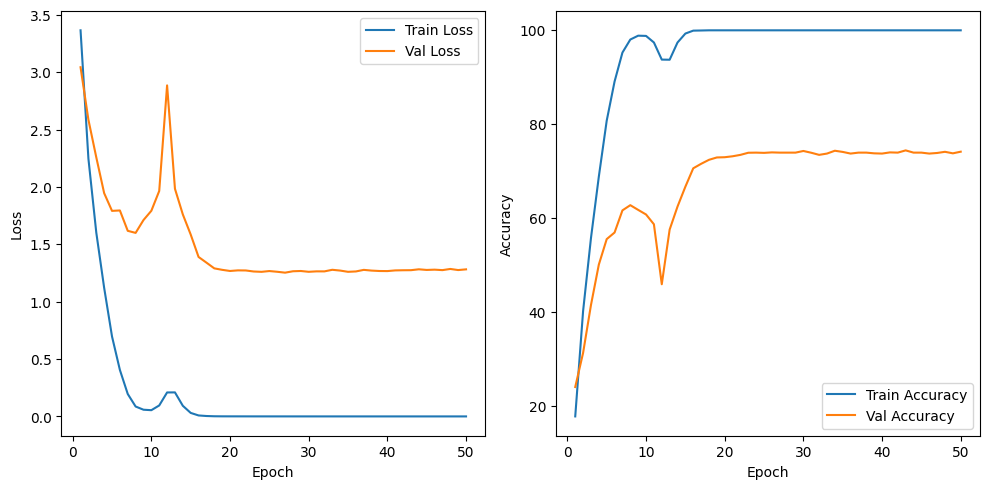

In [2]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
val_predictions = []  # save the results

with torch.no_grad():
    for images, labels in val_data_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        val_predictions.extend(predicted.tolist())
            
with open("val_predictions_resnet.txt", "w") as f:
    for prediction in val_predictions:
        f.write(str(prediction) + "\n")

In [ ]:
import os
import shutil
#for dataset merging

src_folder1 = "AFDB_face_dataset"
src_folder2 = "AFDB_masked_face_dataset"
dst_folder = "merged_dataset"


os.makedirs(dst_folder, exist_ok=True)


for subfolder in os.listdir(src_folder1):
    src_subfolder1 = os.path.join(src_folder1, subfolder)
    src_subfolder2 = os.path.join(src_folder2, subfolder)
    dst_subfolder = os.path.join(dst_folder, subfolder)

    if os.path.isdir(src_subfolder1) and os.path.isdir(src_subfolder2):
        os.makedirs(dst_subfolder, exist_ok=True)


        for file in os.listdir(src_subfolder1):
            src_file = os.path.join(src_subfolder1, file)
            dst_file = os.path.join(dst_subfolder, file)
            shutil.copy2(src_file, dst_file)

        for file in os.listdir(src_subfolder2):
            src_file = os.path.join(src_subfolder2, file)
            dst_file = os.path.join(dst_subfolder, file)
            shutil.copy2(src_file, dst_file)
